In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()
COLORS = [(228/255,26/255,28/255), (55/255,126/255,184/255), (77/255,175/255,74/255), (152/255,78/255,163/255), (255/255,127/255,0/255)] # Colors from https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


In [2]:
def CalcF(nx, y, dx=17/150):
    d = [(i*dx) for i in nx] # Distance from plate to plate
    d1, y1 = [i for ind, i in enumerate(d) if not ind % 2], [i for ind, i in enumerate(y) if not ind % 2]
    d2, y2 = [i for ind, i in enumerate(d) if ind % 2]    , [i for ind, i in enumerate(y) if ind % 2]
    xf, yf = np.average([d1, d2], axis=0), [(y2[i]-y1[i])/(d1[i]-d2[i]) for i in range(round(len(d)/2))] # Force from squeezing (-dx)
    return d, xf, yf

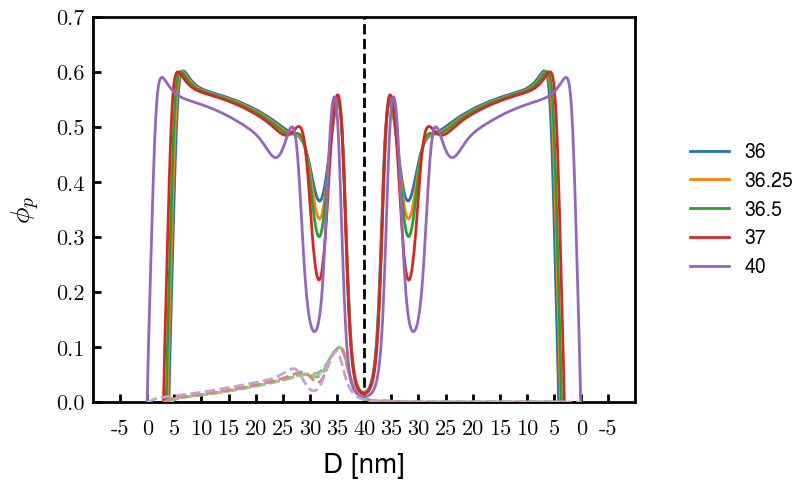

In [453]:
# SYSG Explore
labs = [36, 36.25, 36.5, 37, 40]
read_list = [GIT+'ph_2-2_d{:5d}.dat'.format(round(i*1000)) for i in labs]
max_d = round(max(labs)) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts, block1_scale=15, block1=3, #block1=3 is block5, diff pha format for int runs
                       x1_start = -10, x1_end=max_d*2+10, y1_end=0.70, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 5
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

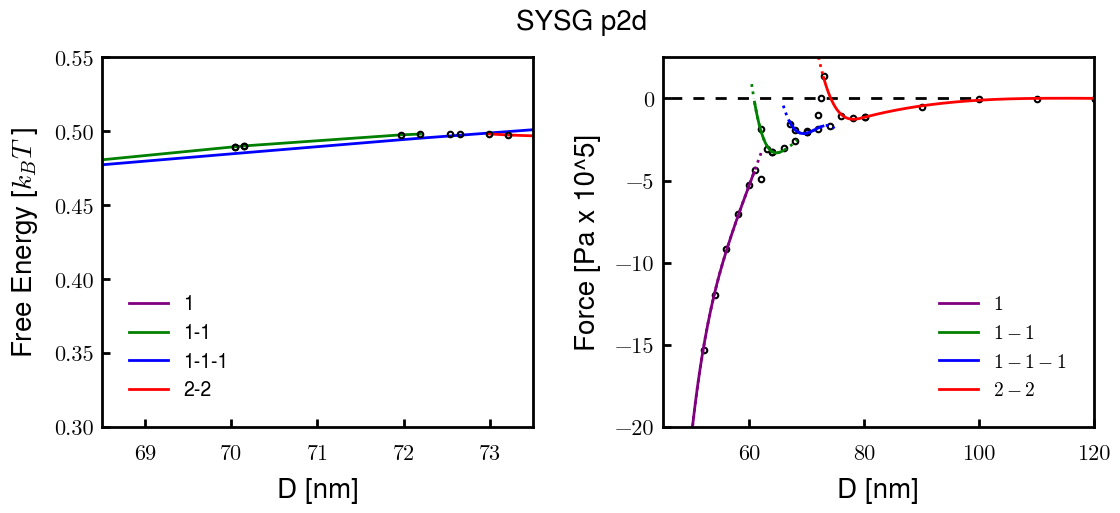

In [443]:
def get_fp(fname, fit=False):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-1)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

# collected
dp2_2, yp2_2, xp2_2, fp2_2, fits2_2 = get_fp('final-2_2.txt', True)
dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-1_1_1.txt', True)
dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-1_1.txt', True)
dp01, yp01, xp01, fp01, fits01 = get_fp('final-1.txt', True)

# raw data
dp1, yp1, xp1, fp1 = get_fp('lx200.txt')
dp2, yp2, xp2, fp2 = get_fp('lx160.txt')
dp3, yp3, xp3, fp3 = get_fp('lx120.txt')
dp4, yp4, xp4, fp4 = get_fp('lx80.txt')
dp5, yp5, xp5, fp5 = get_fp('p1.txt')
dp6, yp6, xp6, fp6 = get_fp('p11.txt')
dp7, yp7, xp7, fp7 = get_fp('p111.txt')
dp8, yp8, xp8, fp8 = get_fp('p22.txt')

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
plt.subplots_adjust(wspace=0.3)

if 1: # freeE collected
    axs[0].plot(dp01, yp01, c='purple', label='1')
    axs[0].plot(dp1_1, yp1_1, c='green', label='1-1')
    axs[0].plot(dp1_1_1, yp1_1_1, c='blue', label='1-1-1')
    axs[0].plot(dp2_2, yp2_2, c='red', label='2-2')
    
if 0: # force collected
    axs[1].plot(xp01, fp01, c='purple', label='1')
    axs[1].plot(xp1_1, fp1_1, c='green', label='1-1')
    axs[1].plot(xp1_1_1, fp1_1_1, c='blue', label='1-1-1')
    axs[1].plot(xp2_2, fp2_2, c='red', label='2-2')
    
if 1: # freeE raw data
    kws = {'marker':'o', 'ms':4, "markerfacecolor":'none',  'c':'k', 'lw':0}
    # axs[0].plot(dp1, yp1,**kws)
    # axs[0].plot(dp2, yp2,**kws)
    # axs[0].plot(dp3, yp3,**kws)
    # axs[0].plot(dp4, yp4,**kws)
    # axs[0].plot(dp5, yp5,**kws)
    axs[0].plot(dp6, yp6,**kws)
    # axs[0].plot(dp7, yp7,**kws)
    axs[0].plot(dp8, yp8,**kws)

if 1: # force raw data
    axs[1].plot(xp1, fp1,**kws)
    axs[1].plot(xp2, fp2,**kws)
    axs[1].plot(xp3, fp3,**kws)
    axs[1].plot(xp4, fp4,**kws)
    axs[1].plot(xp5, fp5,**kws)
    axs[1].plot(xp6, fp6,**kws)
    axs[1].plot(xp7, fp7,**kws)
    axs[1].plot(xp8, fp8,**kws)

if 1: # force fitted
    left, real, right = get_fs(fits01,-1, -1, 61, 62.5)
    axs[1].plot(left[0], left[1], c='purple', ls=':') 
    axs[1].plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
    axs[1].plot(right[0], right[1], c='purple', ls=':')
    
    left, real, right = get_fs(fits1_1, 60.5, 61, 66, 68.5)
    axs[1].plot(left[0], left[1], c='green', ls=':') 
    axs[1].plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
    axs[1].plot(right[0], right[1], c='green', ls=':')
    
    left, real, right = get_fs(fits1_1_1, 66, 67, 73, 75)
    axs[1].plot(left[0], left[1], c='blue', ls=':') 
    axs[1].plot(real[0], real[1], c='blue', ls='-', label=r'$1-1-1$')
    axs[1].plot(right[0], right[1], c='blue', ls=':')
    
    left, real, right = get_fs(fits2_2, 70, 73, 999, 999)
    axs[1].plot(left[0], left[1], c='red', ls=':') 
    axs[1].plot(real[0], real[1], c='red', ls='-', label=r'$2-2$')
    
axs[1].plot([0,100], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

plt.suptitle('SYSG p2d', fontsize=20)
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].set_ylim([0.30, 0.55])
axs[0].set_xlim([55, 80])
axs[1].set_ylabel('Force [Pa x 10^5]')
axs[1].set_ylim([-20, 2.5])
axs[1].set_xlim([45, 120])

for ax in axs:
    ax.set_xlabel('D [nm]')
    ax.legend()

## ZOOM
# axs[0].plot([73.0]*2, [0,1], ':k')
axs[0].set_xlim((68.5, 73.5))
axs[0].set_ylim([None, None])

tjy.ticks(axs)
# f.savefig('./imgs/force_tmp.pdf')
plt.show()

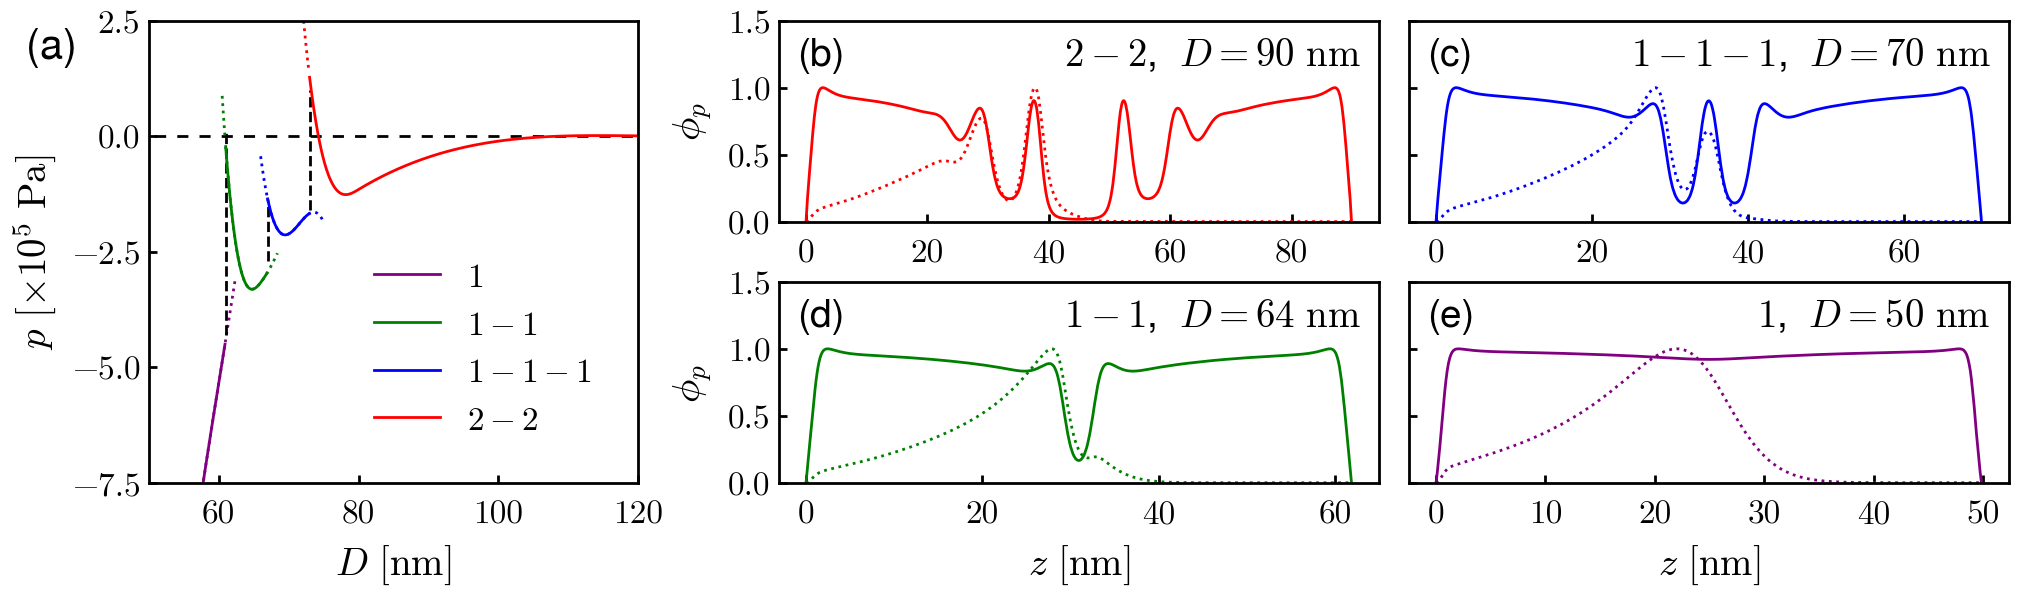

In [439]:
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24

def get_fp(fname, fit=False):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-1)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

def phread(fname): 
    ph = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    return (ph[0], ph[1]/np.max(ph[1]), ph[7]/np.max(ph[7]))

fig = plt.figure(figsize=(24, 6))
gs_left = plt.GridSpec(1, 3, wspace=0.40)
gs_right= plt.GridSpec(2, 3, hspace=0.30, wspace=0.05)

p_ax =fig.add_subplot(gs_left[0])
ph_axes = np.array([fig.add_subplot(gs_right[i,j+1]) for i in range(2) for j in range(2)]).reshape([2,2])

## Forces
p_ax.plot([0,120], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

dp01, yp01, xp01, fp01, fits01 = get_fp('final-1.txt', True)
left, real, right = get_fs(fits01,-1, -1, 61, 62.5)
p_ax.plot(left[0], left[1], c='purple', ls=':') 
p_ax.plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
p_ax.plot(right[0], right[1], c='purple', ls=':')
p_ax.plot([61,61], [-4.3,0.1], 'k', ls='--')

dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-1_1.txt', True)
left, real, right = get_fs(fits1_1, 60.5, 61, 67, 68.5)
p_ax.plot(left[0], left[1], c='green', ls=':') 
p_ax.plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
p_ax.plot(right[0], right[1], c='green', ls=':')
p_ax.plot([67,67], [-2.7,-1.4], 'k', ls='--')

dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-1_1_1.txt', True)
left, real, right = get_fs(fits1_1_1, 66, 67, 73, 75)
p_ax.plot(left[0], left[1], c='blue', ls=':') 
p_ax.plot(real[0], real[1], c='blue', ls='-', label=r'$1-1-1$')
p_ax.plot(right[0], right[1], c='blue', ls=':')
p_ax.plot([73,73], [-1.6,1.], 'k', ls='--')

dp2_2, yp2_2, xp2_2, fp2_2, fits2_2 = get_fp('final-2_2.txt', True)
left, real, right = get_fs(fits2_2, 70, 73, 999, 999)
p_ax.plot(left[0], left[1], c='red', ls=':') 
p_ax.plot(real[0], real[1], c='red', ls='-', label=r'$2-2$')

## PHAS
ph = phread(GIT + 'ph_2-2_d45000.dat')
ph_axes[0][0].plot(ph[0], ph[1], c='red')
ph_axes[0][0].plot(ph[0], ph[2], c='red', ls=':')
ph = phread(GIT + 'ph_1-1-1_d35000.dat')
ph_axes[0][1].plot(ph[0], ph[1], c='blue')
ph_axes[0][1].plot(ph[0], ph[2], c='blue', ls=':')
ph = phread(GIT + 'ph_1-1_d31000.dat')
ph_axes[1][0].plot(ph[0], ph[1], c='green')
ph_axes[1][0].plot(ph[0], ph[2], c='green', ls=':')
ph = phread(GIT + 'ph_1_d25000.dat')
ph_axes[1][1].plot(ph[0], ph[1], c='purple')
ph_axes[1][1].plot(ph[0], ph[2], c='purple', ls=':')

## FORMATTING
p_ax.text(-0.25, 0.92, '(a)', transform=p_ax.transAxes, fontsize=30)
p_ax.set(**{
    'xlim':(50,120),
    'ylim':(-7.5, 2.5),
    'xlabel': r'$D~[\mathrm{nm}]$',
    'ylabel': r'$p~[\times 10^5~\mathrm{Pa}]$',
    'yticks': [-7.5, -5, -2.5, 0, 2.5]
})
p_ax.legend(fontsize=24)

for i, lab, morph, dist in zip(ph_axes.flatten(), ('b', 'c', 'd', 'e'), (r'$2-2$', r'$1-1-1$', r'$1-1$', r'$1$'), (90, 70, 64, 50)):
    i.text(0.03, 0.78, '({:s})'.format(lab), transform=i.transAxes, fontsize=28)
    i.text(0.97, 0.78, r'{:s},  $D = {:d}$'.format(morph, dist)+r'$~\mathrm{nm}$', ha='right', transform=i.transAxes, fontsize=28)
    i.set_ylim((0,1.5))
    if (lab == 'b') or (lab == 'd'): i.set_ylabel(r'$\phi_p$')
    if (lab == 'd') or (lab == 'e'): i.set_xlabel(r'$z~[\mathrm{nm}]$')
    if (lab == 'c') or (lab == 'e'): i.set_yticklabels([])

tjy.ticks([p_ax, *ph_axes.flatten()])
# fig.savefig('./imgs/force.pdf')
plt.show()

## Reset
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

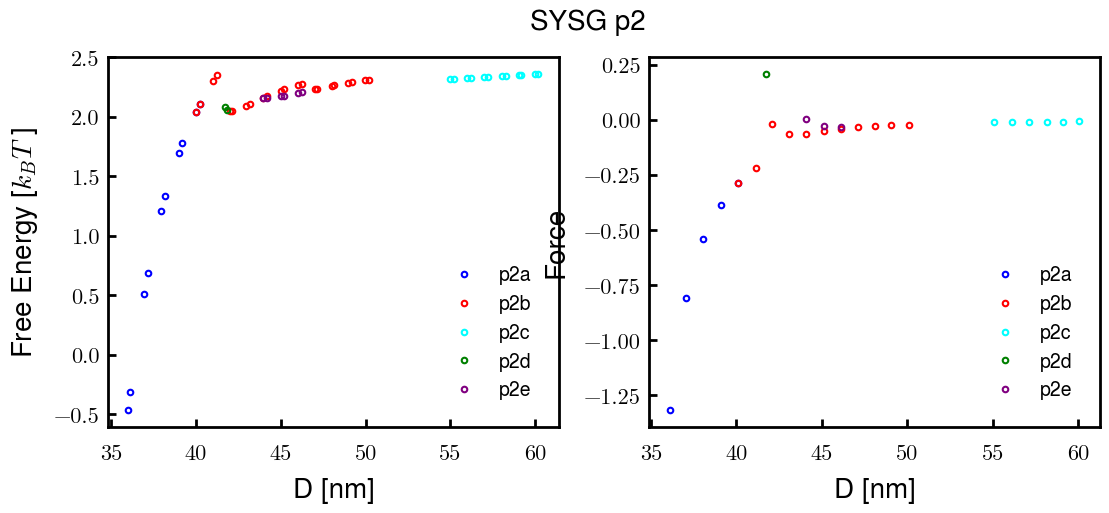

In [5]:
freeE = pd.read_csv(GIT+'p21C.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp21C = freeE.nx, freeE.freeE
dp21C, xp21C, fp21C = CalcF(nx, yp21C)
freeE = pd.read_csv(GIT+'p2b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2b = freeE.nx, freeE.freeE
dp2b, xp2b, fp2b = CalcF(nx, yp2b)
freeE = pd.read_csv(GIT+'p2c_1-12.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2c = freeE.nx, freeE.freeE
dp2c, xp2c, fp2c = CalcF(nx, yp2c)
freeE = pd.read_csv(GIT+'p2d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2d = freeE.nx, freeE.freeE
dp2d, xp2d, fp2d = CalcF(nx, yp2d)
freeE = pd.read_csv(GIT+'p2e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2e = freeE.nx, freeE.freeE
dp2e, xp2e, fp2e = CalcF(nx, yp2e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(dp21C, yp21C, 'o', ms=4, markerfacecolor='none',  c='blue',  label='p2a')
    axs[0].plot(dp2b, yp2b, 'o', ms=4, markerfacecolor='none',  c='red',  label='p2b')
    axs[0].plot(dp2c, yp2c, 'o', ms=4, markerfacecolor='none',  c='cyan',  label='p2c')
    axs[0].plot(dp2d, yp2d, 'o', ms=4, markerfacecolor='none',  c='green',  label='p2d')
    axs[0].plot(dp2e, yp2e, 'o', ms=4, markerfacecolor='none',  c='purple',  label='p2e')
# axs[0].plot(dp21C, yp21C, c='blue',  label='_')
# axs[0].plot(dp2b, yp2b, c='red',  label='_')

if 1:
    axs[1].plot(xp21C, fp21C, 'o', ms=4, markerfacecolor='none', c='blue',  label='p2a')
    axs[1].plot(xp2b, fp2b, 'o', ms=4, markerfacecolor='none', c='red',  label='p2b')
    axs[1].plot(xp2c, fp2c, 'o', ms=4, markerfacecolor='none', c='cyan',  label='p2c')
    axs[1].plot(xp2d, fp2d, 'o', ms=4, markerfacecolor='none', c='green',  label='p2d')
    axs[1].plot(xp2e, fp2e, 'o', ms=4, markerfacecolor='none', c='purple',  label='p2e')
# axs[1].plot(xp21C, fp21C, c='blue', label='_')
# axs[1].plot(xp2b, fp2b, c='red', label='_')

plt.suptitle('SYSG p2', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

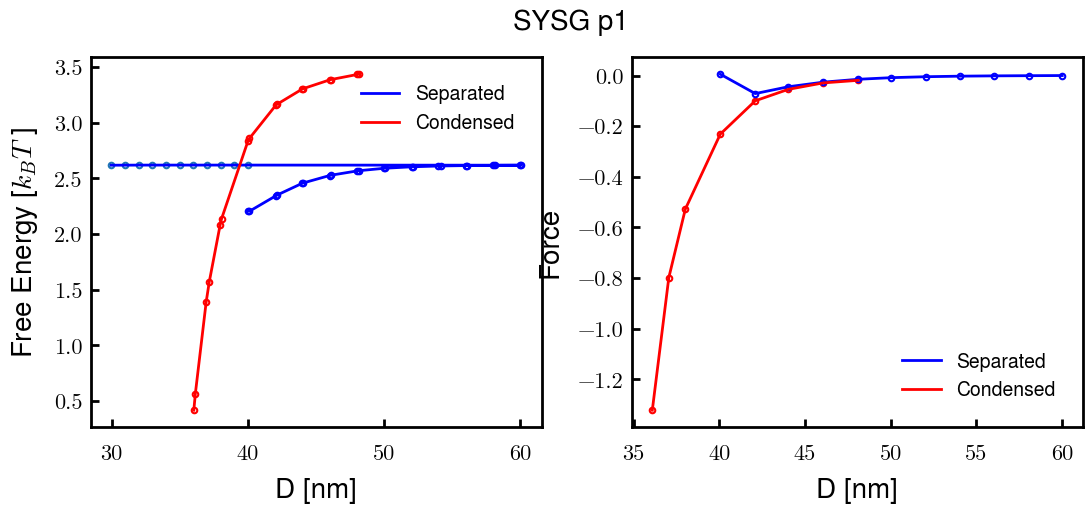

In [4]:
freeE = pd.read_csv(GIT+'p1_4030.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
d4030, y4030 = freeE.nx*17/150/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_c2520.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2520 = freeE.nx, freeE.freeE
dc2520, xc2520, fc2520 = CalcF(nx, yc2520)
freeE = pd.read_csv(GIT+'p1_s3020.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys3020 = freeE.nx, freeE.freeE
ds3020, xs3020, fs3020 = CalcF(nx, ys3020)
freeE = pd.read_csv(GIT+'p1_c1915.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc1915 = freeE.nx, freeE.freeE
dc1915, xc1915, fc1915 = CalcF(nx, yc1915)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(d4030, y4030, 'o', ms=4, markerfacecolor='none',  c='C0',  label='_4030')
    axs[0].plot(dc2520, yc2520, 'o', ms=4, markerfacecolor='none',  c='red',  label='_c2520')
    axs[0].plot(dc1915, yc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[0].plot(ds3020, ys3020, 'o', ms=4, markerfacecolor='none',  c='blue',  label='_s3020')
axs[0].plot([*d4030, *ds3020[::-1]], [*y4030, *ys3020[::-1]], c='blue', label='Separated')
axs[0].plot([*dc2520[::-1], *dc1915[::-1]], [*yc2520[::-1], *yc1915[::-1]], c='red', label='Condensed')

if 1:
    axs[1].plot(xc2520, fc2520, 'o', ms=4, markerfacecolor='none', c='red',  label='_c2520')
    axs[1].plot(xc1915, fc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[1].plot(xs3020, fs3020, 'o', ms=4, markerfacecolor='none', c='blue',  label='_s3020')
axs[1].plot([*xs3020[::-1]], [*fs3020[::-1]], c='blue', label='Separated')
axs[1].plot([*xc2520[::-1], *xc1915[::-1]], [*fc2520[::-1], *fc1915[::-1]], c='red', label='Condensed')

plt.suptitle('SYSG p1', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

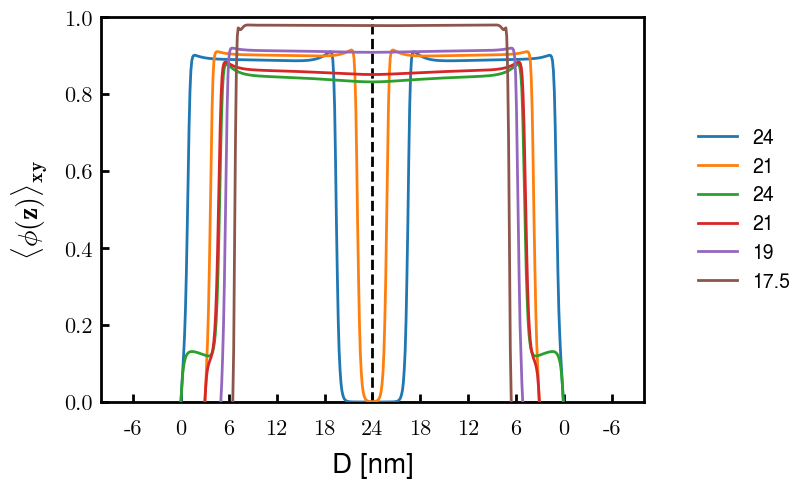

In [5]:
# SYSG 
labs = [24, 21]
read_list = [GIT+'ph_s3020d{:05.0f}.dat'.format(int(i*1000)) for i in labs]
labs2 = [24, 21]
read_list += [GIT+'ph_c2520d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2
labs2 = [19, 17.5]
read_list += [GIT+'ph_c1915d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
block_Ni = [[5]]*len(read_list)
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 6
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

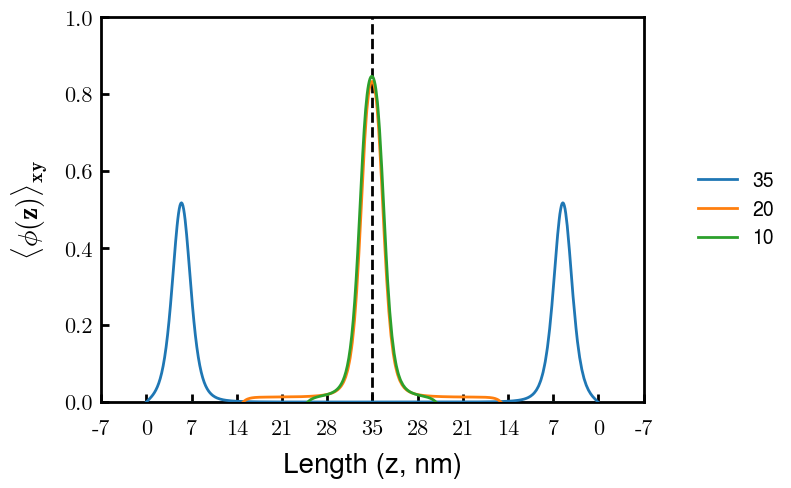

In [6]:
# NFH
labs = [35]
read_list = [GIT+'ph_H30sd{:05d}.dat'.format(int(i*1000)) for i in labs]
labs2 = [20, 10]
read_list += [GIT+'ph_H30cd{:05d}.dat'.format(int(i*1000)) for i in labs2]
labs += labs2
# labs2 = [20, 12.5]
# read_list += [GIT+'ph_H30dd{:05d}.dat'.format(int(i*1000)) for i in labs2]
# labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 7 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

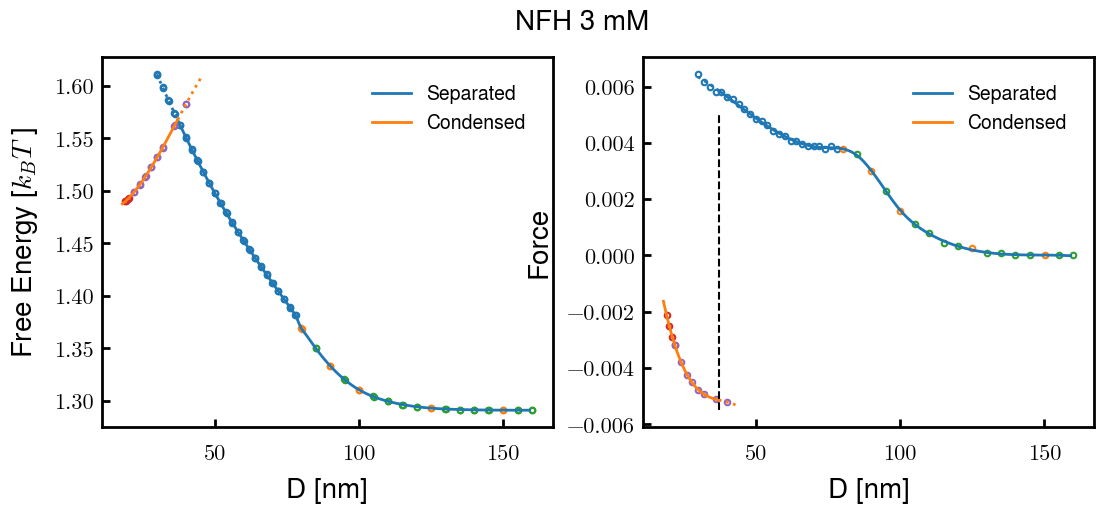

In [7]:
freeE = pd.read_csv(GIT+'NFH_03a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03 = freeE.nx, freeE.freeE
d03, x03, f03 = CalcF(nx, y03)
freeE = pd.read_csv(GIT+'NFH_03b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03b = freeE.nx, freeE.freeE
d03b, x03b, f03b = CalcF(nx, y03b)
freeE = pd.read_csv(GIT+'NFH_03c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03c = freeE.nx, freeE.freeE
d03c, x03c, f03c = CalcF(nx, y03c)
freeE = pd.read_csv(GIT+'NFH_03d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03d = freeE.nx, freeE.freeE
d03d, x03d, f03d = CalcF(nx, y03d)
freeE = pd.read_csv(GIT+'NFH_03e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03e = freeE.nx, freeE.freeE
d03e, x03e, f03e = CalcF(nx, y03e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 1: # 1 to plot, 0 to not
    axs[0].plot(d03, y03,   **kw, label='_H04a')
    axs[0].plot(d03b, y03b, **kw, label='_H04b')
    axs[0].plot(d03c, y03c, **kw, label='_H04c')
    axs[0].plot(d03d[:4], y03d[:4], **kw, label='_H04d')
    axs[0].plot(d03e, y03e, **kw, label='_H04e')
tosortd, tosorty = [*d03, *d03b, *d03c], [*y03, *y03b, *y03c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_03s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d03d[:6], *d03e], [*y03d[:6], *y03e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_03c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x03, f03,   **kw, label='_H04a')
    axs[1].plot(x03b, f03b, **kw, label='_H04b')
    axs[1].plot(x03c, f03c, **kw, label='_H04c')
    axs[1].plot(x03d[:4], f03d[:4], **kw, label='_H04d')
    axs[1].plot(x03e, f03e, **kw, label='_H04e')
tosortx, tosortf = [*x03, *x03b, *x03c], [*f03, *f03b, *f03c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_03s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x03d[:3], *x03e], [*f03d[:3], *f03e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_03c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.18
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_03s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_03s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_03c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_03c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_03s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_03s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_03c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_03c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 3 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

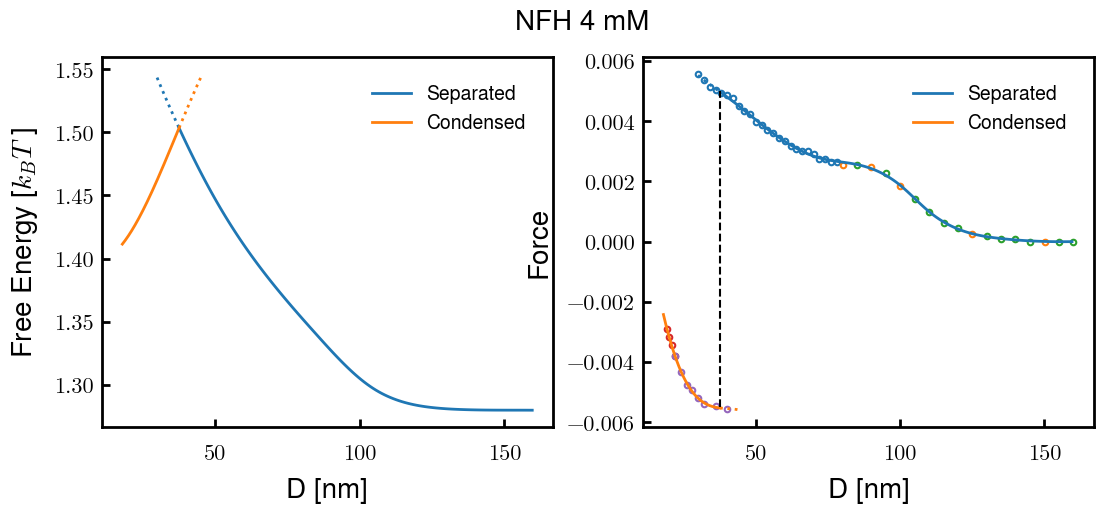

In [8]:
freeE = pd.read_csv(GIT+'NFH_04a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04 = freeE.nx, freeE.freeE
d04, x04, f04 = CalcF(nx, y04)
freeE = pd.read_csv(GIT+'NFH_04b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04b = freeE.nx, freeE.freeE
d04b, x04b, f04b = CalcF(nx, y04b)
freeE = pd.read_csv(GIT+'NFH_04c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04c = freeE.nx, freeE.freeE
d04c, x04c, f04c = CalcF(nx, y04c)
freeE = pd.read_csv(GIT+'NFH_04d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04d = freeE.nx, freeE.freeE
d04d, x04d, f04d = CalcF(nx, y04d)
freeE = pd.read_csv(GIT+'NFH_04e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04e = freeE.nx, freeE.freeE
d04e, x04e, f04e = CalcF(nx, y04e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d04, y04,   **kw, label='_H04a')
    axs[0].plot(d04b, y04b, **kw, label='_H04b')
    axs[0].plot(d04c, y04c, **kw, label='_H04c')
    axs[0].plot(d04d[:4], y04d[:4], **kw, label='_H04d')
    axs[0].plot(d04e, y04e, **kw, label='_H04e')
tosortd, tosorty = [*d04, *d04b, *d04c], [*y04, *y04b, *y04c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d04d[:6], *d04e], [*y04d[:6], *y04e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x04, f04,   **kw, label='_H04a')
    axs[1].plot(x04b, f04b, **kw, label='_H04b')
    axs[1].plot(x04c, f04c, **kw, label='_H04c')
    axs[1].plot(x04d[:4], f04d[:4], **kw, label='_H04d')
    axs[1].plot(x04e, f04e, **kw, label='_H04e')
tosortx, tosortf = [*x04, *x04b, *x04c], [*f04, *f04b, *f04c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x04d[:3], *x04e], [*f04d[:3], *f04e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_04s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_04c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_04c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_04s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_04c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_04c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 4 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

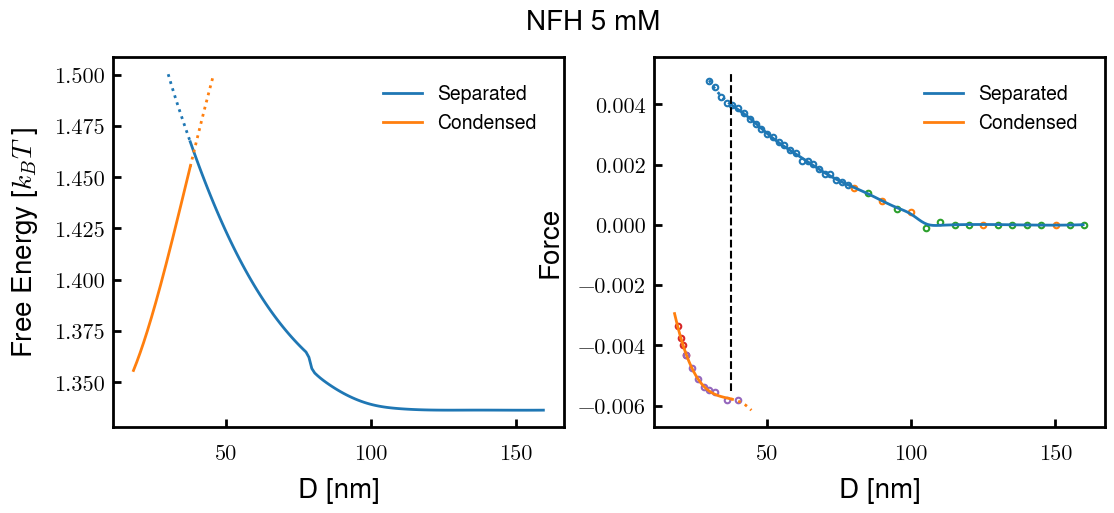

In [9]:
freeE = pd.read_csv(GIT+'NFH_05a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05 = freeE.nx, freeE.freeE
d05, x05, f05 = CalcF(nx, y05)
freeE = pd.read_csv(GIT+'NFH_05b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05b = freeE.nx, freeE.freeE
d05b, x05b, f05b = CalcF(nx, y05b)
freeE = pd.read_csv(GIT+'NFH_05c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05c = freeE.nx, freeE.freeE
d05c, x05c, f05c = CalcF(nx, y05c)
freeE = pd.read_csv(GIT+'NFH_05d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05d = freeE.nx, freeE.freeE
d05d, x05d, f05d = CalcF(nx, y05d)
freeE = pd.read_csv(GIT+'NFH_05e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05e = freeE.nx, freeE.freeE
d05e, x05e, f05e = CalcF(nx, y05e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d05, y05,   **kw, label='_H05a')
    axs[0].plot(d05b, y05b, **kw, label='_H05b')
    axs[0].plot(d05c, y05c, **kw, label='_H05c')
    axs[0].plot(d05d[:4], y05d[:4], **kw, label='_H05d')
    axs[0].plot(d05e, y05e, **kw, label='_H05e')
tosortd, tosorty = [*d05, *d05b, *d05c], [*y05, *y05b, *y05c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_05s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d05d[:6], *d05e], [*y05d[:6], *y05e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_05c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x05, f05,   **kw, label='_H05a')
    axs[1].plot(x05b, f05b, **kw, label='_H05b')
    axs[1].plot(x05c, f05c, **kw, label='_H05c')
    axs[1].plot(x05d[:4], f05d[:4], **kw, label='_H05d')
    axs[1].plot(x05e, f05e, **kw, label='_H05e')
tosortx, tosortf = [*x05, *x05b, *x05c], [*f05, *f05b, *f05c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_05s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x05d[:3], *x05e], [*f05d[:3], *f05e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_05c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_05s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_05s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_05c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_05c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_05s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_05s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_05c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_05c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 5 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

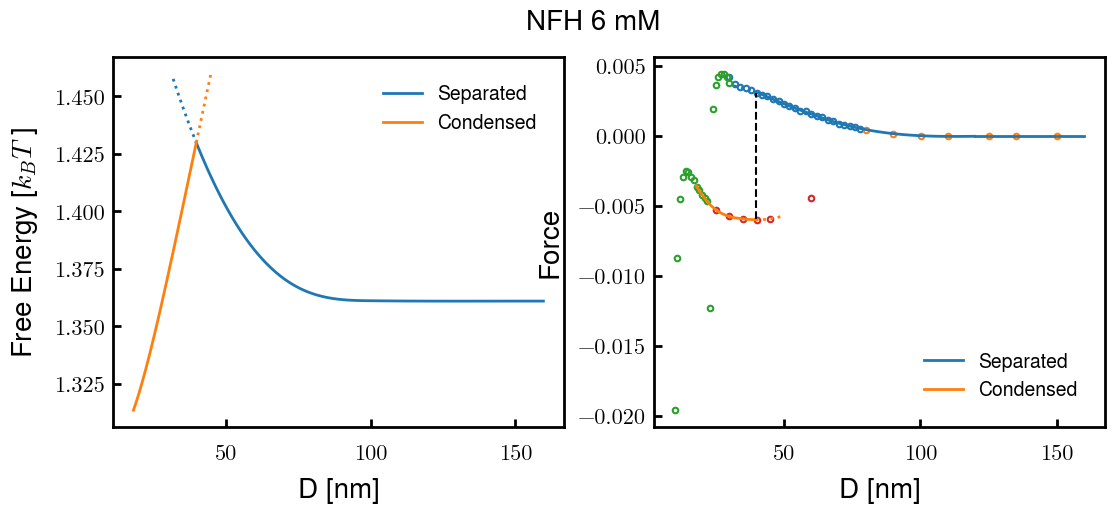

In [10]:
freeE = pd.read_csv(GIT+'NFH_06a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06a = freeE.nx, freeE.freeE
d06a, x06a, f06a = CalcF(nx, y06a)
freeE = pd.read_csv(GIT+'NFH_06b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06b = freeE.nx, freeE.freeE
d06b, x06b, f06b = CalcF(nx, y06b)
freeE = pd.read_csv(GIT+'NFH_06c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06c = freeE.nx, freeE.freeE
d06c, x06c, f06c = CalcF(nx, y06c)
freeE = pd.read_csv(GIT+'NFH_06d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06d = freeE.nx, freeE.freeE
d06d, x06d, f06d = CalcF(nx, y06d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d06a, y06a, **kw, label='_H06a')
    axs[0].plot(d06b, y06b, **kw, label='_H06b')
    axs[0].plot(d06c, y06c, **kw, label='_H06c')
    axs[0].plot(d06d, y06d, **kw, label='_H06d')
tosortx, tosortf = [*d06a, *d06b, *d06c[-16:]], [*y06a, *y06b, *y06c[-16:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d06c[:-16], *d06d], [*y06c[:-16], *y06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06c = UnivariateSpline(XX, YY, s=8e-8)
# axs[0].plot([*d06c[-16:], *d06a, *d06b], [*y06c[-16:], *y06a, *y06b], c='C0')
# axs[0].plot([*d06c[:-16], *d06d], [*y06c[:-16], *y06d], c='C1')

if 1: 
    axs[1].plot(x06a, f06a, **kw, label='_F06a')
    axs[1].plot(x06b, f06b, **kw, label='_F06b')
    axs[1].plot(x06c, f06c, **kw, label='_F06c')
    axs[1].plot(x06d, f06d, **kw, label='_F06d')
tosortx, tosortf = [*x06a[4:], *x06b], [*f06a[4:], *f06b]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06s = UnivariateSpline(XX, YY, s=2e-08)
tosortx, tosortf = [*x06c[4:-8], *x06d], [*f06c[4:-8], *f06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06c = UnivariateSpline(XX, YY, s=1e-08)
# axs[1].plot([*x06c[-8:], *x06a, *x06b], [*f06c[-8:], *f06a, *f06b], c='C0')
# axs[1].plot([*x06c[:-8], *x06d], [*f06c[:-8], *f06d], c='C1')

xx = 39.735
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_06s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_06c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 120), F_06s(np.arange(xx, 120)), c='C0', label='Separated') 
axs[1].plot(np.arange(120, 161, 20), [0]*3, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_06c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0031],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 6 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

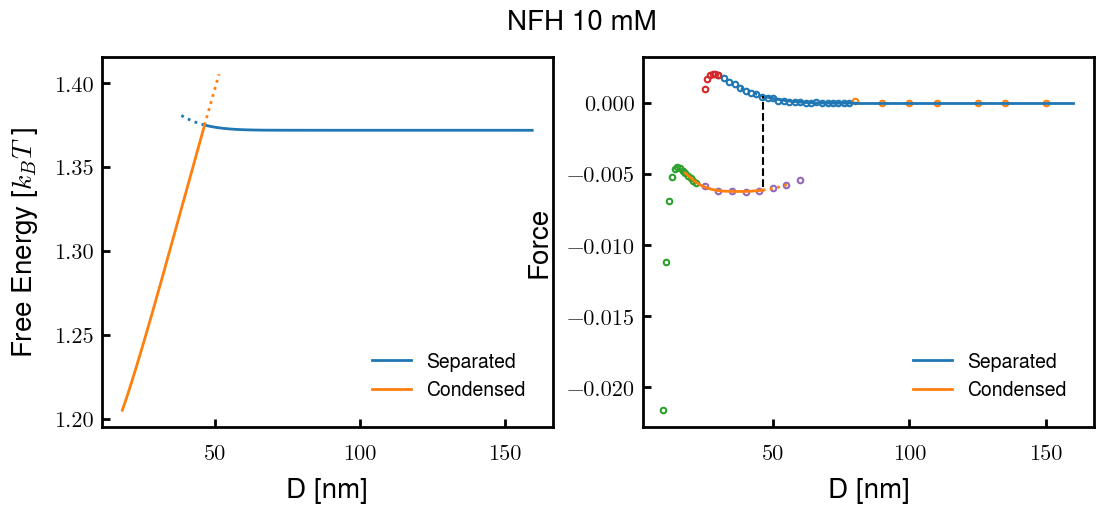

In [11]:
freeE = pd.read_csv(GIT+'NFH_10a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10a = freeE.nx, freeE.freeE
d10a, x10a, f10a = CalcF(nx, y10a)
freeE = pd.read_csv(GIT+'NFH_10b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10b = freeE.nx, freeE.freeE
d10b, x10b, f10b = CalcF(nx, y10b)
freeE = pd.read_csv(GIT+'NFH_10c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10c = freeE.nx, freeE.freeE
d10c, x10c, f10c = CalcF(nx, y10c)
freeE = pd.read_csv(GIT+'NFH_10d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10d = freeE.nx, freeE.freeE
d10d, x10d, f10d = CalcF(nx, y10d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d10a, y10a, **kw, label='_H10a')
    axs[0].plot(d10b, y10b, **kw, label='_H10b')
    axs[0].plot(d10c, y10c, **kw, label='_H10c')
    axs[0].plot(d10d, y10d, **kw, label='_H10d')
tosortx, tosortf = [*d10a, *d10b, *d10c[28:]], [*y10a, *y10b, *y10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d10c[:26], *d10d[:-2]], [*y10c[:26], *y10d[:-2]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10c = UnivariateSpline(XX, YY, s=8e-8)

if 1: 
    axs[1].plot(x10a, f10a, **kw, label='_F10a')
    axs[1].plot(x10b, f10b, **kw, label='_F10b')
    axs[1].plot(x10c[:13], f10c[:13], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10c[15:], f10c[15:], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10d, f10d, **kw, label='_F10d')
tosortx, tosortf = [*x10a, *x10b, *x10c[28:]], [*f10a, *f10b, *f10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x10c[:13], *x10d], [*f10c[:13], *f10d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10c = UnivariateSpline(XX, YY, s=8e-08)

xx = 46.35
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_10s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_10c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()
# axs[0].set_xlim(46, 47)
# axs[0].set_ylim(1.36, 1.38)

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 81), F_10s(np.arange(xx, 81)), c='C0', label='Separated') 
axs[1].plot(np.arange(80, 161, 20), [0]*5, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_10c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0005],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 10 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

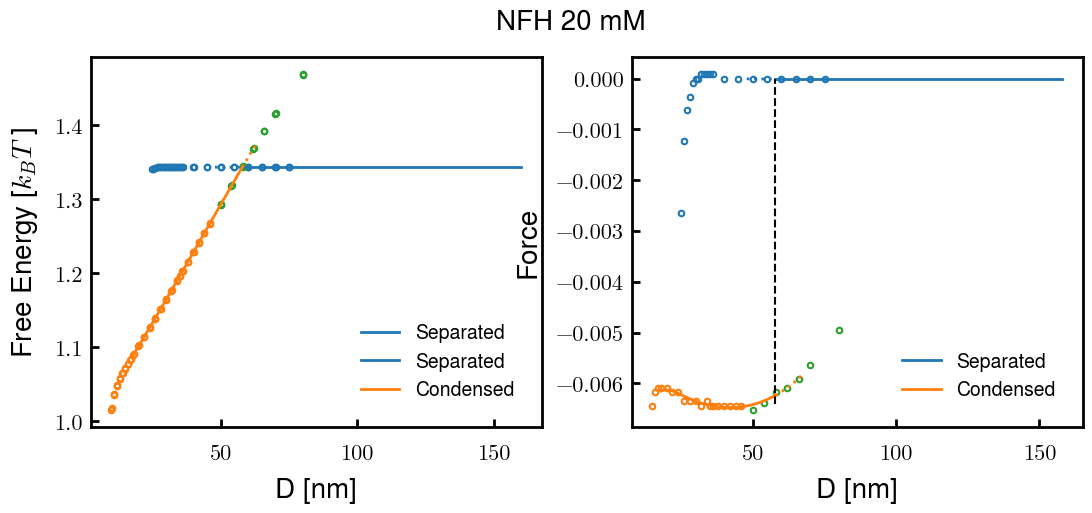

In [12]:
freeE = pd.read_csv(GIT+'NFH_20s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x20s, y20s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_20c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x20c, y20c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_20c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x20c2, y20c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 1: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20c = UnivariateSpline(XX, YY, s=8e-08)

if 1: 
    axs[1].plot(x20s, y20s, **kw, label='_NFHs')
    axs[1].plot(x20c[5:], y20c[5:], **kw, label='_NFHc')
    axs[1].plot(x20c2, y20c2, **kw, label='_NFHc')
tosortx, tosortf = x20s, y20s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x20c[5:], *x20c2], [*y20c[5:], *y20c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20c = UnivariateSpline(XX, YY, s=8e-08)

xx = 57.94
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 60), H_20s(np.arange(xx, 60)), c='C0', label='Separated') 
axs[0].plot(np.arange(60, 161, 20), H_20s([60]).tolist()*6, c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_20c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_20s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_20c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0064, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 20 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

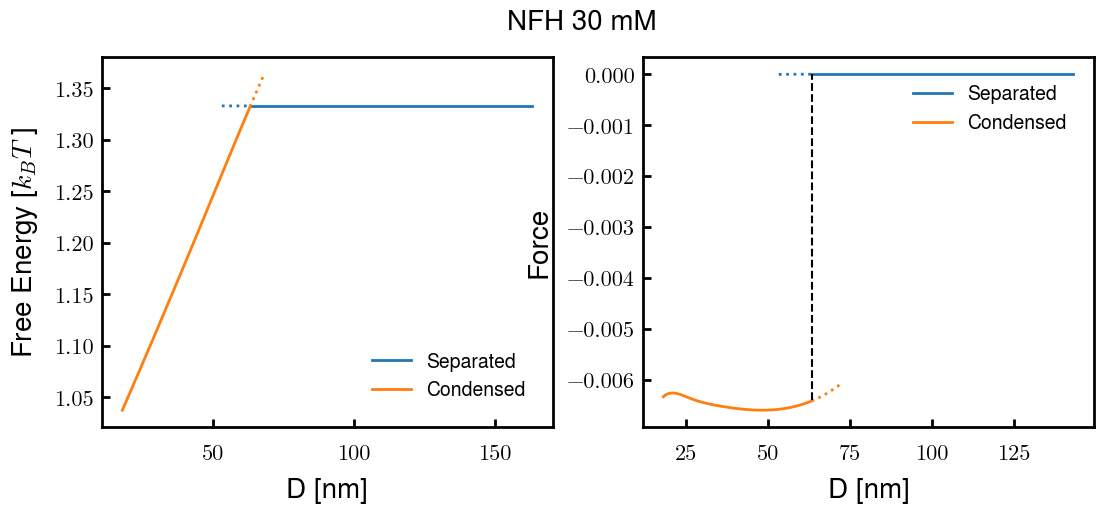

In [13]:
freeE = pd.read_csv(GIT+'NFH_30s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x30s, y30s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_30c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x30c, y30c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_30c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x30c2, y30c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_30s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_30c = UnivariateSpline(XX, YY, s=8e-08)

if 0: 
    axs[1].plot(x30s, y30s, **kw, label='_NFHs')
    axs[1].plot(x30c[5:], y30c[5:], **kw, label='_NFHc')
    axs[1].plot(x30c2, y30c2, **kw, label='_NFHc')
tosortx, tosortf = x30s, y30s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_30s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x30c[5:], *x30c2], [*y30c[5:], *y30c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_30c = UnivariateSpline(XX, YY, s=8e-08)

xx = 63.25
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[0].plot(np.arange(xx, 60), H_30s(np.arange(xx, 60)), c='C0', label='Separated') 
axs[0].plot(np.arange(xx, 164, 20), H_30s([60]).tolist()*6, c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_30c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_30c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_30s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_30c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_30c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0064, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 30 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

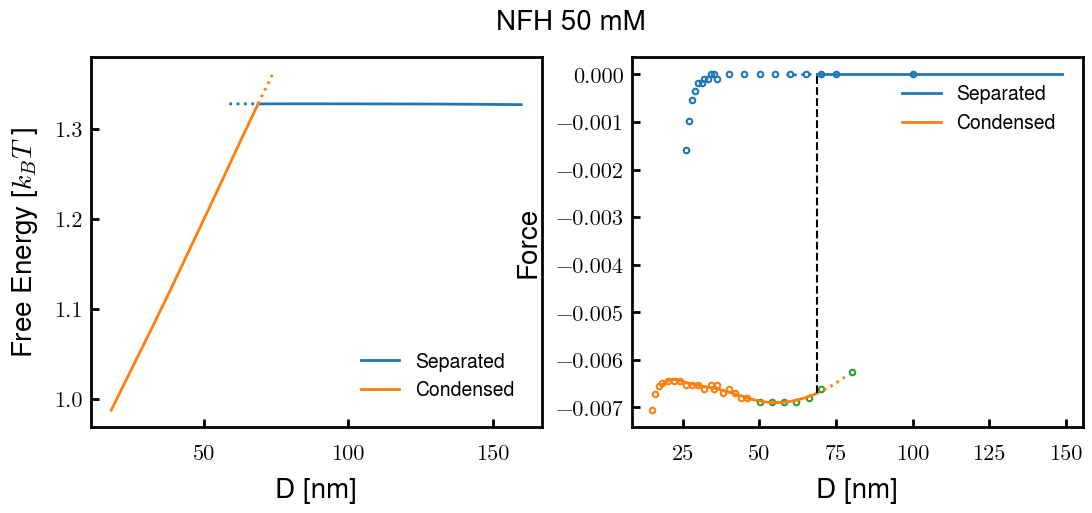

In [14]:
freeE = pd.read_csv(GIT+'NFH_50s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x50s, y50s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_50c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x50c, y50c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_50c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x50c2, y50c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50c = UnivariateSpline(XX, YY, s=1e-08)
# axs[0].plot(ds, ys, c='C0', label='Separated')
# axs[0].plot([*dc, *dc2], [*yc, *yc2], c='C1', label='Condensed')

if 1: 
    axs[1].plot(x50s, y50s, **kw, label='_NFHs')
    axs[1].plot(x50c[5:], y50c[5:], **kw, label='_NFHc')
    axs[1].plot(x50c2, y50c2, **kw, label='_NFHc')
tosortx, tosortf = x50s, y50s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x50c[5:], *x50c2], [*y50c[5:], *y50c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50c = UnivariateSpline(XX, YY, s=6e-08)
# axs[1].plot(x50s, y50s, c='C0', label='Separated')
# axs[1].plot([*x50c, *x50c2], [*y50c, *y50c2], c='C1', label='Condensed')

xx = 68.85
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_50s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_50c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_50c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0067, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 50 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

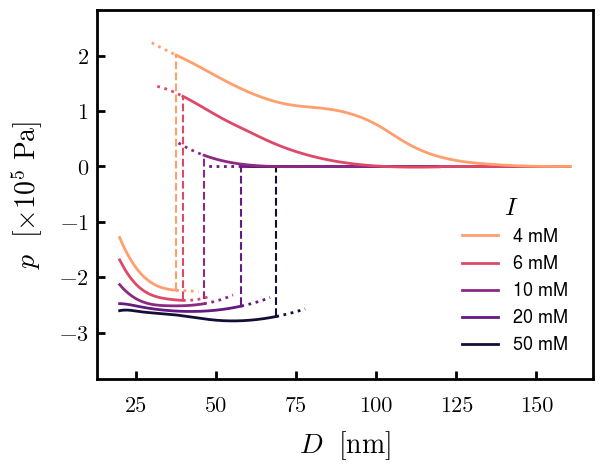

In [15]:
## Plotting
f, ax = plt.subplots(1,1)
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
scaling = 5 # For order unity y-axis
pas *= 10**scaling

# NFH 50
xx = 68.85
c = cividis[7]
# plt.plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
plt.plot(np.arange(60, 161, 20),      len(np.arange(60,161,20))*[0], c=c, label='50 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_50c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),        pas*F_50c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0067, 0.00], '--', c=c, lw=1.5)

# # NFH 30
# xx = 63.25
# c = cividis[6]
# plt.plot(np.arange(xx-10, xx+0.01, 0.1), pas*F_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
# # axs[1].plot(np.arange(xx, 100), F_30s(np.arange(xx, 100)), c='C0', label='Separated') 
# plt.plot(np.arange(60, 161, 20),         len(np.arange(60,161,20))*[0], c=c, label='30 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1),    pas*F_30c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
# plt.plot(np.arange(xx, xx+10),           pas*F_30c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
# plt.plot([xx,xx], [pas*-0.0064, 0.00], '--', c=c, lw=1.5)

# NFH 20
xx = 57.94
c = cividis[5]
plt.plot(np.arange(xx-10, xx+0.01, 0.1), pas*F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 161, 20),         len(np.arange(xx,161,20))*[0], c=c, label='20 mM')
plt.plot(np.arange(20, xx+0.01, 0.1),    pas*F_20c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),           pas*F_20c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0062, 0.00],'--', c=c, lw=1.5)

# NFH 10
xx = 46.35
c = cividis[4]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 81),             pas*F_10s(np.arange(xx, 81)), c=c, label='10 mM') 
plt.plot(np.arange(80, 161, 20), [0]*5, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_10c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_10c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0005], '--',c=c,lw=1.5)

# NFH 06
xx = 39.735
c = cividis[2]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 120),            pas*F_06s(np.arange(xx, 120)), c=c, label='6 mM') 
plt.plot(np.arange(120, 161, 20), [0]*3, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_06c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_06c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0031],'--', c=c, lw=1.5)

# Splitting start #
# end = 120
# step = 70
# plt.plot(np.arange(xx, step),            0.7+pas*F_06s(np.arange(xx, step)), c='red', label='_Shifted 6 mM') 
# plt.plot(np.arange(step+40, end+40),            pas*F_06s(np.arange(step, end)), c='red', label='Shifted 6 mM') 
###################

# NFH 05
# xx = 37.62
# c = cividis[2]
# plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_05s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
# plt.plot(np.arange(xx, 161),          pas*F_05s(np.arange(xx,161)), c=c, label='5 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_05c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
# plt.plot(np.arange(xx, xx+8),         pas*F_05c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
# plt.plot([xx,xx], [pas*-0.0055, pas*0.005], '--', c=c, lw=1.5)

# NFH 04
xx = 37.62
c = cividis[0]
plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_04s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
plt.plot(np.arange(xx, 161),          pas*F_04s(np.arange(xx,161)), c=c, label='4 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_04c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
plt.plot(np.arange(xx, xx+8),         pas*F_04c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
plt.plot([xx,xx], [pas*-0.0055, pas*0.005], '--', c=c, lw=1.5)

# NFH 03
# xx = 37.18
# c = cividis[0]
# plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_03s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
# plt.plot(np.arange(xx, 161),          pas*F_03s(np.arange(xx,161)), c=c, label='3 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_03c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
# plt.plot(np.arange(xx, xx+8),         pas*F_03c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
# plt.plot([xx,xx], [pas*-0.0050, pas*0.0058], '--', c=c, lw=1.5)

plt.ylim(pas*-0.0095, pas*0.007)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,1), useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(16)
plt.gca().yaxis.offsetText.set_fontfamily('Serif')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='lower right', fontsize=13)
# plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(0.99, 0.5))
plt.xlabel(r'$D\ \ [\mathrm{nm}]$')
plt.ylabel(r'$p\ \ [\times 10^{:d}$'.format(scaling) + r'$\ \mathrm{Pa}]$')
plt.text(140, -0.87, r'$I$', fontsize=18)
# plt.gcf().text(0.000, 0.82, '(c)', fontsize=24)
tjy.ticks()
if True: plt.savefig('./imgs/fprof.eps')
plt.show()

In [31]:
# NFH
def int_04(ax):
    max_d = 80
    stepL = 0
    step  = 15 
    c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
    colors = (COLORS[1], COLORS[0], COLORS[2])

    f_04 = [70]
    read_04 = [GIT+'ph_H04cd{:05d}.dat'.format(int(i*1000)) for i in f_04]
    lshi_04 = [0]*5
    f_06 = (40, 50)
    # read_06 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in f_06[:-1]] + [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in f_06[-1:]] 
    read_06 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in f_06]
    lshi_06 = [0]*5
    f_10 = [20, 30]
    read_10 = [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in f_10] #+ [GIT+'ph_H10dd12500.dat'] 
    lshi_10 = [0]*5
    
    cs_read = (read_10, read_06, read_04)
    cs_lshi = (lshi_10, lshi_06, lshi_04)
    # j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
    j_shift = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
    lss = ('-', '-')
    # lss = ( (0,(5,2)), (0,(5,2,1,2)) )
    # lightfs = np.arange(1.00, 0.39, -0.10)
    fs = (f_10, f_06, f_04)
    
    for ind in [0, 1, 2]:
        for indj, j in enumerate(range(len(cs_read[ind]))):
            plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], 
                                x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], block1=4, block1_scale = 1, 
                                x1_start = -stepL, x1_end=max_d, ls=lss[indj],
                                y1_start=0, y1_end=0.0175, show=False)

    return [f_04, f_06, f_10], np.array(colors[:3])

#     for ind in [0, 1, 2]:
#         for indj, j in enumerate(range(len(cs_read[ind]))):
#             plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], 
#                                 x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], block1=4, block1_scale = 4, 
#                                 xi_end = round(fs[ind][indj]/(17.0/150)), 
#                                 x1_start = -stepL, x1_end=max_d, show=False)
#                                 # x1_start = -step, x1_end=max_d*2+step, y1_start=-0.1, y1_end=1.90, show=False)

#     return [f_04, f_06, f_10], colors[:3]

def int_06(ax):
    max_d = 80
    stepL = 0
    step  = 15 
    c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
    colors = (COLORS[1], COLORS[0], COLORS[2])

    f_04 = [50]
    read_04 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in f_04]
    lshi_04 = [0]*5
    f_06 = (20, 30)
    read_06 = [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in f_06]
    lshi_06 = [0]*5

    cs_read = (read_06, [], read_04)
    cs_lshi = (lshi_06, [], lshi_04)
    # j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
    j_shift = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
    # lightfs = np.arange(1.00, 0.39, -0.10)
    lss = ('-', '-')
    fs = (f_06, f_04)

    for ind in [0,2]:
        for indj, j in enumerate(range(len(cs_read[ind]))):
            plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], 
                                x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], block1=4, block1_scale = 1, 
                                x1_start = -stepL, x1_end=max_d, ls=lss[indj],
                                y1_start=0, y1_end=0.0175, show=False)
                                # x1_start = -step, x1_end=max_d*2+step, y1_start=-0.1, y1_end=1.90, show=False)

    return [f_04, f_06], np.array([colors[0], colors[2]])

def plot_pha_feed(read_file, ax, labs=[], b0=1.0, show=True,
             block_Ni = None, block1 = None, block1_scale = None,
             x1_shift = None, y1_shift = None, ls = None,
             y1_start=0, y1_end=1.00, x1_start=0, x1_end=None, xi_end=None, 
             color='C0', lightf=1.00):
    ## VERSION for single file onto input ax
    
    from matplotlib import animation, rc
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    from matplotlib import ticker
    from urllib.error import HTTPError

    # Defaults
    if not labs:     labs     = read_file
    if not x1_shift: x1_shift = 0
    if not y1_shift: y1_shift = 0
    if not block_Ni: block_Ni = [5]
    if not ls: ls = '-'

    block_Nik = block_Ni
    a = 1
    b = 1
    c = 1
    names = ['rx', 'phA']
    for j in range(len(block_Nik)):
        names += ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
        a += 1
        b += 2
        c += block_Nik[j]

    names += ['phB']
    try: df = pd.read_csv(read_file, sep="\s+", skiprows=0, names=names)

    except HTTPError: 
        print('{} not found'.format(read_file))
    Nx = len(df.index)

    for i in range(len(block_Nik)*2):
        names.remove('*'*(i+1))
        df = df.drop('*'*(i+1),axis=1)

    Nx = len(df.index)
    rows = range(0, Nx)

    phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
    phAr = phAr.fillna(0) # with 0s rather than NaNs
    phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
    phAT = phAT.fillna(0) # with 0s rather than NaNs
    ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
    ph1r = ph1r.fillna(0) # with 0s rather than NaNs

    phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
    phB = phB.fillna(0) # with 0s rather than NaNs

    ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
    ph1r.insert(0, 'rx', df.iloc[:,0])

    # phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
    # phAT.insert(0, 'rx', df.iloc[:,0])

    for i in range(Nx):
        phAr.iloc[i, 0] = df.iloc[i,0]
        phAr.iloc[i, 1] = df.iloc[i,1] 
        phB.iloc[i, 0] = df.iloc[i, 0]
        phB.iloc[i, 1] = df.iloc[i, 1 + sum(block_Nik) + len(block_Nik)] 
        
    lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
    ushi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

    # Plot total density (zorder 3)
    lshi[0] = phAr.iloc[:xi_end,0] + x1_shift 
    ushi[0] = phAr.iloc[:xi_end,1] + y1_shift

    # if not lightf: ax.plot(lshi[0], ushi[0], color = color, zorder = 2, alpha=1.0, label=labs[0])
    # else:          ax.plot(lshi[0], ushi[0], color = tjy.lighten_color(color, amount=lightf), zorder = 2, alpha=1.0, label=labs[0])

    # Plot chain types (zorder 2)
    step = 1
    for j in range(len(block_Nik)):
    #Plot block densities (zorder 3)
        for i in range(block_Nik[j]):
            if not y1_shift: 
                if (i == block1): 
                    if not block1_scale: ax.plot(lshi[0], ph1r.iloc[:,i+step], ls=ls,  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
                    else: ax.plot(lshi[0], block1_scale*ph1r.iloc[:,i+step], ls=ls,  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
            else: 
                if (i == block1): 
                    if not block1_scale: ax.plot(lshi[0], ph1r.iloc[:,i+step]+y1_shift, '-',  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
                    else: ax.plot(lshi[0], block1_scale*ph1r.iloc[:,i+step]+y1_shift, '-',  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')

        step += block_Nik[j]

    conf = [Patch(facecolor=color, edgecolor='k', lw=1.5)]
    conf += [
              Line2D([0], [0], color='k', ls='-'),
              Line2D([0], [0], color='k', ls='--'),
            ]
    tjy.ticks()        
    plt.ylabel(r'$\phi_p$', fontsize=24)
    ax.set_xlabel(r'$z\ [\mathrm{nm}]$')
    ax.set_yscale('linear')
    ax.set_ylim(y1_start, y1_end)
    ax.set_xlim(x1_start, x1_end)
    # leg = plt.legend(loc=1)
    if show: plt.show()
    
    return ax

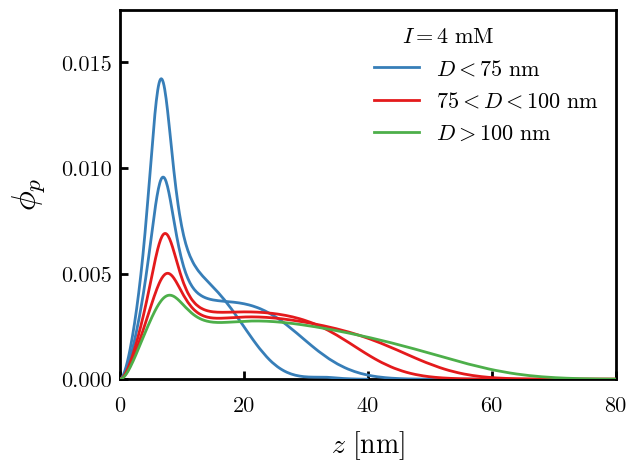

In [39]:
import matplotlib.patches as mpatches

nf, naxs = plt.subplots(1,1)
int_04p, int_04c = int_04(naxs)
naxs.set_yticks([0, 0.005, 0.01, 0.015])
naxs.set_ylabel(r'$\phi_p$')

## LEGENDS ## 
custom_legend = [Line2D([0], [0], color=int_04c[i], lw=2) for i in range(3)]
plt.text(0.57, 0.91, r'$I = 4\ \mathrm{mM}$', transform=naxs.transAxes, fontsize=16)
labs = [r'$D < 75\ \mathrm{nm}$', r'$75 < D <  100\ \mathrm{nm}$', r'$D > 100\ \mathrm{nm}$'] 
naxs.legend(handles=custom_legend, labels=labs, bbox_to_anchor=(1.03, 0.95), loc='upper right', fontsize=16)

## TEXTS ## 
cd_factor = 0.7 # Text color darkening factor
bbox=dict(boxstyle='square,pad=0.1', facecolor='white', edgecolor='none')
props = lambda c: dict(xycoords='data', textcoords='data', c=c, fontsize=18, va='center', ha='left', bbox=bbox)
plt.annotate(r'', xy=(12, 0.0120), **props(int_04c[0]*cd_factor))
plt.annotate(r'', xy=(14, 0.0090), **props(int_04c[0]*cd_factor))
plt.annotate(r'', xy=(17, 0.0060), **props(int_04c[1]))
plt.annotate(r'',xy=(30, 0.0040), **props(int_04c[1]))
plt.annotate(r'',xy=(48, 0.0025), **props(int_04c[2]*cd_factor))
# plt.annotate(r'$40\ \mathrm{nm}$', xy=(12, 0.0120), **props(int_04c[0]*cd_factor))
# plt.annotate(r'$60\ \mathrm{nm}$', xy=(14, 0.0090), **props(int_04c[0]*cd_factor))
# plt.annotate(r'$80\ \mathrm{nm}$', xy=(17, 0.0060), **props(int_04c[1]))
# plt.annotate(r'$100\ \mathrm{nm}$',xy=(30, 0.0040), **props(int_04c[1]))
# plt.annotate(r'$140\ \mathrm{nm}$',xy=(48, 0.0025), **props(int_04c[2]*cd_factor))
tjy.ticks()
plt.savefig('./imgs/fdens2.eps')

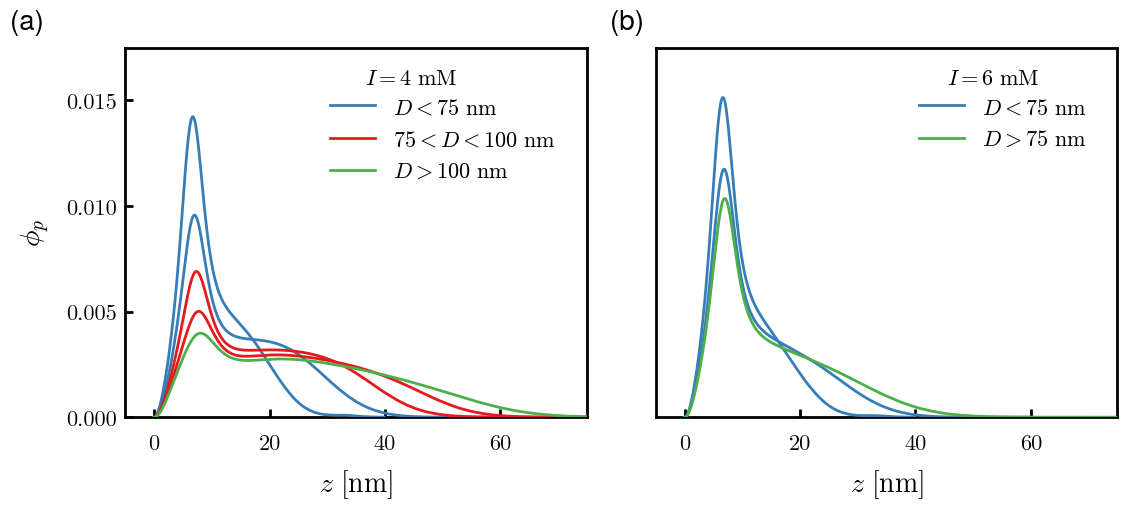

In [28]:
## Plotting
# f, ax = plt.subplots(1,1)
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals
scaling = 5 # For order unity y-axis
pas *= 10**scaling

## END POINT NEW ##

nf, naxs = plt.subplots(1,2, figsize=[plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]]) 
int_04p, int_04c = int_04(naxs[0])
int_06p, int_06c = int_06(naxs[1])
naxs[0].set_yticks([0, 0.005, 0.01, 0.015])
naxs[0].set_ylabel(r'$\phi_p$')
naxs[1].set_yticks([])
naxs[1].set_ylabel('')

## LEGENDS ## 
custom_legend = [Line2D([0], [0], color=int_04c[i], lw=2) for i in range(3)]
plt.text(0.52, 0.90, r'$I = 4\ \mathrm{mM}$', transform=naxs[0].transAxes, fontsize=16)
labs = [r'$D < 75\ \mathrm{nm}$', r'$75 < D <  100\ \mathrm{nm}$', r'$D > 100\ \mathrm{nm}$'] 
naxs[0].legend(handles=custom_legend, labels=labs, bbox_to_anchor=(1.00, 0.95), loc='upper right', fontsize=16)

custom_legend = [Line2D([0], [0], color=int_06c[i], lw=2) for i in range(2)]
plt.text(0.63, 0.90, r'$I = 6\ \mathrm{mM}$', transform=naxs[1].transAxes, fontsize=16)
labs = [r'$D < 75\ \mathrm{nm}$', r'$D > 75\ \mathrm{nm}$'] 
naxs[1].legend(handles=custom_legend, labels=labs, bbox_to_anchor=(1.00, 0.95),  loc='upper right', fontsize=16)

## TEXTS ## 
cd_factor = 0.7 # Text color darkening factor
plt.subplots_adjust(wspace=0.15)
plt.text(-0.25, 1.05, '(a)', transform=naxs[0].transAxes, fontsize=20)
plt.annotate(r'', xy=(12, 0.0120), xycoords=naxs[0].transData, color = int_04c[0]*cd_factor, fontsize = 18)
plt.annotate(r'', xy=(14, 0.0090), xycoords=naxs[0].transData, color = int_04c[0]*cd_factor, fontsize = 18)
plt.annotate(r'', xy=(17, 0.0060), xycoords=naxs[0].transData, color = int_04c[1], fontsize = 18)
plt.annotate(r'',xy=(30, 0.0040), xycoords=naxs[0].transData, color = int_04c[1], fontsize = 18)
plt.annotate(r'',xy=(48, 0.0025), xycoords=naxs[0].transData, color = int_04c[2]*cd_factor, fontsize = 18)

plt.text(-0.10, 1.05, '(b)', transform=naxs[1].transAxes, fontsize=20)
plt.annotate(r'', xy=(12, 0.0120), xycoords=naxs[1].transData, color = int_06c[0]*cd_factor, fontsize = 18)
plt.annotate(r'', xy=(16, 0.0070), xycoords=naxs[1].transData, color = int_06c[0]*cd_factor, fontsize = 18)
plt.annotate(r'',xy=(30, 0.0030), xycoords=naxs[1].transData, color = 'g', fontsize = 18)

tjy.ticks(naxs)

plt.savefig('./imgs/fdens_rev.eps')

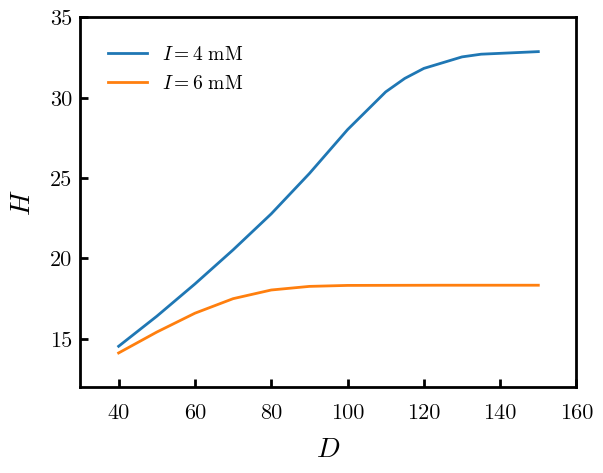

In [95]:
def phL_H(ph_name):
    phA = pd.read_csv(ph_name, sep="\s+", skiprows=0)
    dx  = (phA.iloc[1,0] - phA.iloc[0, 0]) #Assuming equally spaced
    sum1 = 0
    sum2 = 0
    for i in range(0, np.max(phA.index)):
        phL  = phA.iloc[i,3] + phA.iloc[i,4] + phA.iloc[i,5] + phA.iloc[i,6] + phA.iloc[i,7]
        sum1 += phL
        sum2 += phL * phA.iloc[i, 0]
    sum1 *= dx 
    sum2 *= dx
    rGibbs =  2 * sum2 / sum1
    return rGibbs
norm = 32.9 # From nfh_vis.ipynb

d_04 = (75, 67.5, 65, 60, 57.5, 55, 50, 45, 40, 35, 30, 25, 20)
read_04 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in d_04[:1]] \
            + [GIT+'ph_H04cd{:05d}.dat'.format(int(i*1000)) for i in d_04[1:6]] + [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in d_04[6:-4]] \
            + [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in d_04[-4:]] # + [GIT+'ph_H04ed12000.dat'] 
d_06 = (75, 62.5, 50, 45, 40, 35, 30, 25, 20)
read_06 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in d_06[:2]] \
            + [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in d_06[2:-4]] \
            + [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in d_06[-4:]] # + [GIT+'ph_H04ed12000.dat'] 

H_i04 = [phL_H(i) for i in read_04]
H_i06 = [phL_H(i) for i in read_06]

plt.subplots(1,1)
plt.plot(2*np.array(d_04), np.array(H_i04), '-', label = '$I = 4\ \mathrm{mM}$')
plt.plot(2*np.array(d_06), np.array(H_i06), '-', label = '$I = 6\ \mathrm{mM}$')

plt.ylabel(r'$H$')
plt.xlabel(r'$D$')
plt.ylim(12, 35)
plt.xlim(30, 160)
plt.legend()
tjy.ticks()

plt.savefig('./imgs/fheights.eps')

In [20]:
def H_find(filename, alg, thresh=1e-04):
    ## Alg options: thresh, maxpt, norm
    import pandas as pd, numpy as np
    from urllib.error import HTTPError
    import sys

    try: df = pd.read_csv(filename, sep="\s+", skiprows=0)
    except HTTPError: 
        print('{} not found'.format(filename))
    
    Nx = len(df.index)
    rows = range(0, Nx)

    phA = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
    phA = phA.fillna(0) # with 0s rather than NaNs

    for i in range(Nx):
        phA.iloc[i, 0] = df.iloc[i,0]
        phA.iloc[i, 1] = df.iloc[i,1] 
    
    if alg == 'norm':
        dx = (phA.iloc[1,0] - phA.iloc[0, 0]) #Assuming equally spaced

        sum = 0
        sum2 = 0
        for i in range(0, np.max(phA.index)):
            sum += phA.iloc[i, 1]
            sum2 += phA.iloc[i, 1] * phA.iloc[i, 0]
        sum *= dx 
        sum2 *= dx
        rGibbs =  2 * sum2 / sum 
        
        return rGibbs

    print('Alg not recognized')
    return

f_04 = (75, 62.5, 50, 39, 35)
read_04 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in f_04[:-2]] + [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in f_04[-2:]]
lshi_04 = [0]*5
f_06 = (30, 25, 20)
read_06 = [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in f_06]
lshi_06 = [0]*5

print(tjy.H_find(read_04[1], alg='norm'))

124.89335708969017


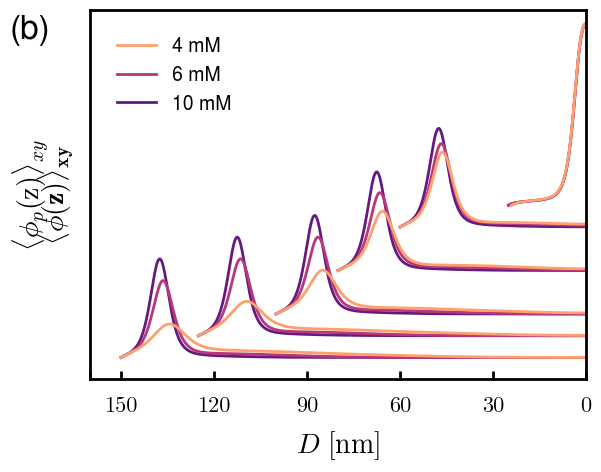

In [21]:
# NFH
max_d = 75
stepL = 5
step  = 15 
c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
colors = [c[0], c[3], c[5], c[2], c[5], c[7]]

# read_03 = [GIT+'ph_H03bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H03ad30000.dat'] + [GIT+'ph_H03ed12000.dat'] 
# lshi_03 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12)]
read_04 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H04ad30000.dat'] + [GIT+'ph_H04ed12000.dat'] 
lshi_04 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12)]
read_06 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H06ad30000.dat'] + [GIT+'ph_H06dd12500.dat'] 
lshi_06 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12.5)]
read_10 = [GIT+'ph_H10bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H10ad30000.dat'] + [GIT+'ph_H10dd12500.dat'] 
lshi_10 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12.5)]

cs_read = [read_04, read_06, read_10]
cs_lshi = [lshi_04, lshi_06, lshi_10]
j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
lightfs = np.arange(1.00, 0.39, -0.10)

fig, ax = plt.subplots(1,1)


## MAIN ##
for ind in (2,1,0):
    for indj, j in enumerate(range(len(cs_read[ind]))):
        tjy.plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], #lightf = lightfs[indj],
                            x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], 
                            x1_start = -stepL, x1_end=max_d, y1_start=-0.10, y1_end=1.60, show=False)



ax.set_xlim(0, max_d)
xrange = np.concatenate([np.array([-stepL]), np.arange(0, max_d+0.1, step)])  # points to relabel
xsim   = np.concatenate([np.array(['']), np.arange(2*max_d, 0-2*step, -2*step)]) # relabels

plt.xticks(xrange, xsim)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gcf().text(0.000, 0.40, r'$\langle \phi_p(\mathrm{z}) \rangle_{xy}$', 
               rotation=90, fontsize=20)
plt.gcf().text(0.000, 0.82, '(b)', fontsize=24)
plt.xlabel(r'$D\ [\mathrm{nm}]$')

hands, labs = ax.get_legend_handles_labels()
plt.legend([hands[i] for i in (14,7,0)], ['4 mM', '6 mM', '10 mM'], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='upper left')

tjy.ticks()
if True: plt.savefig('./imgs/fphas.eps')
plt.show()

Success: 534 == 534.
Actual Lx: 60.52


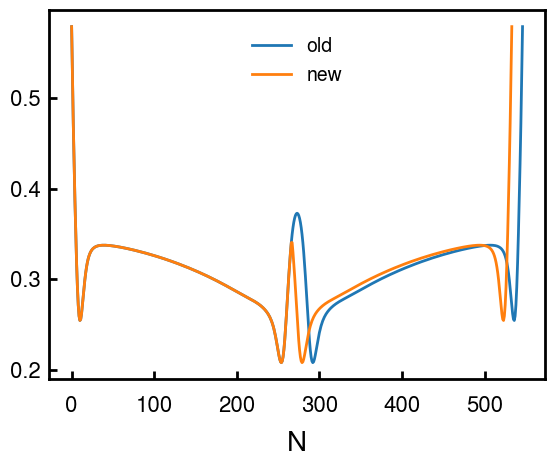

In [34]:
## Adjust D (half-space)
filename = 'W_lx062-p11.dat' 
fill_mid = True # Add to mid (Sep) if True, add to ends (Con) if False
dx = 17/150
new_Lx = 60.5
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
old_N = len(df.index)

if N >= old_N: 
    if fill_mid == True:
        mid = round(old_N/2)
        rem = df.iloc[mid,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-2*mid)], columns=names)
        new = pd.concat([df.iloc[:round(old_N/2)], rem, df.iloc[-round(old_N/2):]], ignore_index=True)
    else: 
        end = 0 
        rem = df.iloc[end,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-old_N)], columns=names)
        new = pd.concat([rem.iloc[:round((N-old_N)/2)], df, rem[round((N-old_N)/2):]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    print('Actual Lx: {:.2f}'.format(N*dx))
    new.to_csv('./imgs/W_in{}.dat'.format(round(new_Lx)), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True: 
    plt.plot(df.w1, label='old')
    plt.plot(new.w1, label='new')
    plt.legend()
    plt.xlabel('N')

Success: 1412 == 1412.


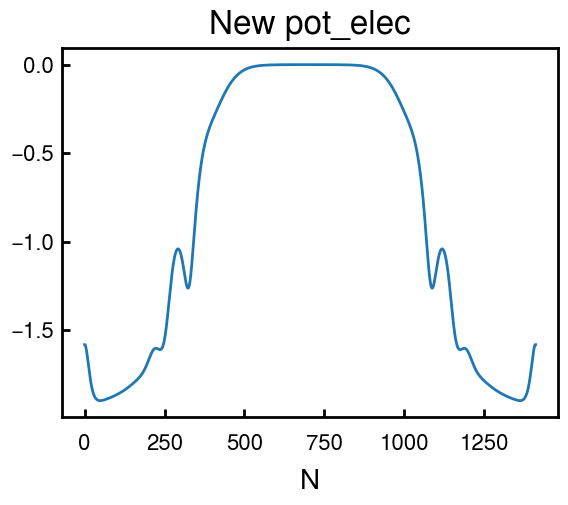

In [6]:
## SINGLE --> DOUBLE WA
filename = 'W_a031x105_orig.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 160
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
# display(df)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True:
    plt.plot(new.pot_elec)
    plt.title('New pot_elec')
    plt.xlabel('N')

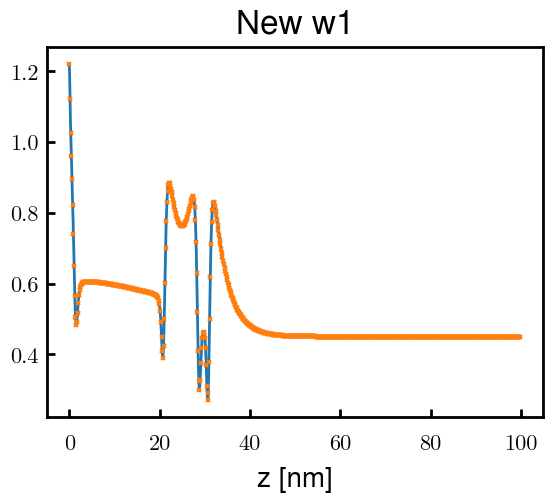

In [7]:
## SINGLE dx1 --> dx2
from scipy.interpolate import CubicSpline
filename = 'W_a040x145_1D.dat' #Nx = 75, dx = 17.0/150
dx1 = 17.0/150 # Old
dx2 = 0.15 # New
Lx = 100-dx1
Nx1, Nx2 = round(Lx/dx1), round(Lx/dx2)

x1 = np.arange(0, Lx, dx1)
x2 = np.arange(0, Lx, dx2)

names = ['*', 'w1', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if True: 
    test_frame = df.w1
    cs = CubicSpline(x1, test_frame)
    plt.plot(x1, test_frame)
    plt.plot(x2, cs(x2), 'x', markerfacecolor='w', ms=3)

    plt.title('New w1')
    plt.xlabel('z [nm]')
    tjy.ticks()
    plt.show()

A = []
for i in [1, 3,4,5]:
    cs = CubicSpline(x1, df.iloc[:, i])
    A = [*A, cs(x2)]
fill = np.array(['[']*(Nx2))
fill2= np.array([']']*(Nx2))
A = [fill, A[0], fill2, A[1], A[2], A[3]]
new = pd.DataFrame(A).transpose()
new.to_csv('./imgs/W_dx{:d}.dat'.format(int(dx2*100)), sep=' ', float_format='%10.5e', header=False, index=False)